<h1>Dataset</h1>

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
import re

# Dimensionality Reduction
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap
import umap.plot

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Calculations
from scipy.stats import zscore

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.N

<h3>Load Data</h3>

In [2]:
demo_stats_df = pl.read_csv("Coursework Data/DemoStats.csv", null_values=None)
household_spend_df = pl.read_csv("Coursework Data/HouseholdSpend.csv", null_values=None)

<h3>Merging Data</h3>

In [3]:
merged_df = demo_stats_df.join(
    household_spend_df,
    on=["CODE"],
    how="inner"
)

# Drop ID columns
merged_df = merged_df.drop(["GEO", "CODE"])

# Describe the data
merged_df.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,2.278714,1.770631,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,10.420684,8.140557,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

<h3>Null Values</h3>

In [4]:
total_data_points = merged_df.height
print(f"Total data points: {total_data_points}")
# Define a function to convert NA to None
def convert_na_to_nulls(df):
    return df.with_columns([
        pl.col(col).replace("NA", None).alias(col)
        if df.schema[col] == pl.Utf8 else pl.col(col)
        for col in df.columns
    ])

# Convert NA to None on both dataframes
merged_df = convert_na_to_nulls(merged_df)

# Get total nulls for each column
def count_na_strings(df):
    total_rows = df.height
    return {
        col: {
            "null_count": df[col].null_count(),
        }
        for col in df.columns
        if df[col].null_count() > 0
    }

merged_df_nulls = count_na_strings(merged_df)
print(f"Data Null Count: {merged_df_nulls}")

Total data points: 868970
Data Null Count: {'ECYPTAMED': {'null_count': 87459}, 'ECYPMAMED': {'null_count': 96444}, 'ECYPFAMED': {'null_count': 131837}, 'ECYHTAMED': {'null_count': 92709}, 'ECYHMAMED': {'null_count': 101698}, 'ECYHFAMED': {'null_count': 137900}, 'ECYMTNMED': {'null_count': 92709}}


<p>Here we can see that demo stats has numerous columns with null values. All of these columns represent the median of a certain population.</p>

<p>Since the null values represent less than 1% of the data, we can substitute for the median of the column.</p>

<h3>Turn Data Into Numbers</h3>

In [5]:
# Function to turn any string into a number
def convert_strings_to_numbers(df):
    if hasattr(df, "to_pandas"):
        df = df.to_pandas()

    for col in df.columns:
        if col in ["CODE", "GEO"]:
            continue  # skip explicitly excluded columns

        if df[col].dtype == "object" or pd.api.types.is_string_dtype(df[col]):
            if (df[col] == "NA").any():
                continue  # skip if "NA" appears in the column
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                df[col] = df[col].astype("category").cat.codes

    return df

# Convert df
merged_df = convert_strings_to_numbers(merged_df)

# Convert to polars
merged_df = pl.from_pandas(merged_df)

merged_df.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,2.278714,1.770631,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,10.420684,8.140557,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

<h3>Handle Nulls</h3>

In [6]:
def substitute_nulls_with_median(df: pl.DataFrame) -> pl.DataFrame:
    # Convert to Pandas
    df_pd = df.to_pandas()

    for col in df_pd.columns:
        if pd.api.types.is_numeric_dtype(df_pd[col]):
            if df_pd[col].isnull().sum() > 0:
                median = df_pd[col].median()
                print(f"Filling nulls in '{col}' with median = {median}")
                df_pd[col] = df_pd[col].fillna(median)

    # Back to Polars
    return pl.from_pandas(df_pd)


merged_df = substitute_nulls_with_median(merged_df)

merged_df_nulls = count_na_strings(merged_df)
print(f"Data Null Count: {merged_df_nulls}")

Filling nulls in 'ECYPTAMED' with median = 41.3
Filling nulls in 'ECYPMAMED' with median = 40.0
Filling nulls in 'ECYPFAMED' with median = 42.5
Filling nulls in 'ECYHTAMED' with median = 41.1
Filling nulls in 'ECYHMAMED' with median = 40.0
Filling nulls in 'ECYHFAMED' with median = 42.5
Filling nulls in 'ECYMTNMED' with median = 55.0
Data Null Count: {}


<h3>Negative Values</h3>

In [7]:
# Get total negative values for each column
def count_negative_values(df):
    return {
        col: {
            "negative_count": df[col].filter(df[col] < 0).len(),
        }
        for col in df.columns
        if df.schema[col] in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                              pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                              pl.Float32, pl.Float64]
        and df[col].filter(df[col] < 0).len() > 0
    }

# Get total negative values for each dataframe
merged_df_negatives = count_negative_values(merged_df)
print(f"Data Negative Values Count: {merged_df_negatives}")

Data Negative Values Count: {'HSTT001': {'negative_count': 28}, 'HSTE001ZBS': {'negative_count': 163557}, 'HSWH040S': {'negative_count': 255858}, 'HSWH041S': {'negative_count': 15436}, 'HSWH042S': {'negative_count': 19205}}


<p>We can see that demo stats has no negative values, so we don't need to modify this dataset as of right now.</p>
<p>For household spending, we can see that there are negative values in the dataset:<p>
<ul>
<li>HSTT001 - Total expenditure,Household Expenditures (Category Summary),Dollars</li>
<li>HSTE001ZBS - Total non-current consumption,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH040S,Net purchase price of owned residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH041S - Net purchase price of owned secondary residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH042S - Net purchase price of other owned properties,Household Expenditures (Category Summary),Dollars</li>
</ul>
<p>We can easily tell that the first two varaibles cannot be negative, since they desribe expenditures, and because they capture sums of outflows. The next 3 are tricky, because these variables reflect the net purchase price of owned residences, secondary residences, and other properties, they can indeed be negative if the proceeds from selling those properties exceed any purchase or improvement costs, thereby indicating a net inflow rather than an outflow.</p>
<p>Therefore, we will replaced the negatives in the first two variables, and keep the last three.</p>

In [8]:
# Function to replace negative values with median
def replace_negatives_with_median(df, cols):
    updated_df = df.clone()

    for col in cols:
        if col in df.columns:
            median = df.select(pl.col(col).filter(pl.col(col) >= 0).median()).item()
            neg_count = df.select((pl.col(col) < 0).sum()).item()

            if neg_count > 0:
                print(f"Replacing {neg_count} negative values in '{col}' with median = {median}")
                updated_df = updated_df.with_columns(
                    pl.when(pl.col(col) < 0).then(median).otherwise(pl.col(col)).alias(col)
                )
    return updated_df

def remove_negative_rows(df, cols):
    updated_df = df.clone()

    for col in cols:
        if col in df.columns:
            neg_count = df.select((pl.col(col) < 0).sum()).item()

            if neg_count > 0:
                print(f"Removing {neg_count} rows with negative values in '{col}'")
                updated_df = updated_df.filter(pl.col(col) >= 0)
    return updated_df

# Replace negative values with median
#merged_df = replace_negatives_with_median(merged_df, ["HSTT001", "HSTE001ZBS"])
# Remove negative values
merged_df = remove_negative_rows(merged_df, ["HSTT001", "HSTE001ZBS"])
merged_df_negatives = count_negative_values(merged_df)
print(f"Data Negative Values Count: {merged_df_negatives}")

Removing 28 rows with negative values in 'HSTT001'
Removing 163557 rows with negative values in 'HSTE001ZBS'
Data Negative Values Count: {'HSWH040S': {'negative_count': 92301}, 'HSWH041S': {'negative_count': 11752}, 'HSWH042S': {'negative_count': 11436}}


<h3>General Clean Up</h3>
<p>Here, we will be cleaning up any data that is redundant, such as rows with straight zeros, columns where the mean and std are both zero, implying that the column is constant, and any other data that is not useful.</p>

In [9]:
# Drop any rows that contain straight 0's in all columns
columns_to_check = [col for col in merged_df.columns if merged_df.schema[col] in (pl.Int64, pl.Float64)]
merged_df = merged_df.filter(
    ~pl.all_horizontal([pl.col(col) == 0 for col in columns_to_check])
)

# Drop any columns where the mean and std are both 0
columns_to_drop = [
    col for col in merged_df.columns
    if merged_df.schema[col] in (pl.Int64, pl.Float64)
    and merged_df[col].mean() == 0
    and merged_df[col].std() == 0
]
merged_df = merged_df.drop(columns_to_drop)


merged_df.describe()

statistic,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,…,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",45.32736,16.743865,44.468185,39.879673,38.186946,36.349227,35.841402,38.90524,37.352966,35.742548,35.21239,3.162692,23.37986,12.789991,12.05614,12.959478,23.949479,45.32736,2.140502,2.426384,2.573528,2.733338,3.014384,2.918709,3.048859,3.039452,3.02636,2.825421,2.773723,2.850337,3.110348,2.801791,2.244984,1.727044,1.067264,1.00493,…,242375.263227,121868.196765,117979.635404,14467.228171,9038.717602,94473.68963,190.796079,84.609491,106.186588,3697.765283,3437.625064,1962.806877,1474.818188,260.140219,1454.1927,119052.873761,3179.9546,10102.355568,13092.636306,18227.159442,106.099711,66013.732792,2675.554839,4386.868667,1268.511836,351.240582,917.271254,31203.527587,4315.457106,1753.137546,854.717533,21883.331903,54.389448,1282.169932,844.277964,437.891968,1060.32412
"""std""",188.918111,73.803066,185.528093,164.749757,157.424106,150.218825,148.360248,160.801048,154.23883,147.80745,145.771566,13.517334,93.823475,54.527564,52.034661,52.867026,96.221427,188.918111,10.207018,11.221434,11.599388,11.149624,11.25802,10.8494,11.877395,11.89591,11.90687,11.352044,11.465213,12.716419,14.992905,13.933697,11.355473,8.820249,5.503686,6.170175,…,1.0811e6,551324.442001,537183.31755,63170.750632,50479.357085,433092.503158,861.039175,388.99574,537.161406,14891.635367,13924.882575,8421.391057,6177.80712,1519.585595,5951.376534,532519.782258,15450.594747,42752.98507,66016.42972,78268.40789,677.195357,312463.440104,14610.445994,15131.742512,6101.000468,2274.654969,4064.546694,98702.901927,13881.963732,6194.528894,5183.144266,72795.187519,240.518948,7108.745439,5491.337794,2182.570242,4375.568214
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",7.0,2.0,7.0,7.0,6.0,6.0,5.0,6.0,6.0,5.0,5.0,0.0,3.0,2.0,2.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

<h3>Correlated Variables</h3>
<p>Now, we will be looking for correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

<p>Start by removing anything with the word retirement, pension, insurnace, premium
except for target column calculation variable</p>
<p>We do this because we are trying to predict the target variable, which is the total expenditure. We want to remove any variables that are correlated with the target variable, so that we can get a better prediction.</p>

In [10]:
columns_to_drop = [
    "ECYINDFINA", "HSEP001", "HSSH006", "HSSH014", "HSSH019", "HSSH044", "HSEP002",
    "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", "HSEP008", "HSEP009",
    "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR025", "HSRV011"
]

for col in columns_to_drop:
    if col in merged_df.columns:
        merged_df = merged_df.drop(col)
    else:
        print(f"Column not found: {col}")

Column not found: HSEP001
Column not found: HSEP002
Column not found: HSEP003
Column not found: HSEP004
Column not found: HSEP005
Column not found: HSEP006
Column not found: HSEP007
Column not found: HSEP008
Column not found: HSEP009
Column not found: HSTR025
Column not found: HSRV011


<p>Now, lets create a function to remove correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

In [11]:
def summarize_perfectly_correlated_vars(df):
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns

    correlated_pairs = {
        "var_1": [],
        "var_2": [],
        "correlation": []
    }

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            corr_value = corr_matrix.select(columns[j]).row(i)[0]
            if corr_value == 1.0 or corr_value == -1.0:
                correlated_pairs["var_1"].append(columns[i])
                correlated_pairs["var_2"].append(columns[j])
                correlated_pairs["correlation"].append(corr_value)

    return pl.DataFrame(correlated_pairs).sort("correlation", descending=True)


# Get highly correlated variables
df_correlated = summarize_perfectly_correlated_vars(merged_df)
print("Df Highly Correlated Variables:", df_correlated)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Df Highly Correlated Variables: shape: (181, 3)
┌────────────┬────────────┬─────────────┐
│ var_1      ┆ var_2      ┆ correlation │
│ ---        ┆ ---        ┆ ---         │
│ str        ┆ str        ┆ f64         │
╞════════════╪════════════╪═════════════╡
│ ECYBASPOP  ┆ ECYPTAPOP  ┆ 1.0         │
│ ECYBASHHD  ┆ ECYMTNHHD  ┆ 1.0         │
│ ECYBASHHD  ┆ ECYHSZHHD  ┆ 1.0         │
│ ECYBASHHD  ┆ ECYHTYHHD  ┆ 1.0         │
│ ECYBASHHD  ┆ ECYTENHHD  ┆ 1.0         │
│ …          ┆ …          ┆ …           │
│ ECYGENHPOP ┆ ECYTCAHPOP ┆ 1.0         │
│ HSSH001S   ┆ HSSH001    ┆ 1.0         │
│ HSFD001S   ┆ HSFD001    ┆ 1.0         │
│ HSHF001S   ┆ HSHF001    ┆ 1.0         │
│ HSSH012    ┆ HSSH012B   ┆ 1.0         │
└────────────┴────────────┴─────────────┘


<p>We can see that certain variables are highly correlated with other variables, this is because we have a large number of aggregate variables that are derived from the same underlying data. To fix this, we will drop variables with a correlation count of over 1, since these can be determined as having redundancy.</p>

In [12]:
def remove_perfectly_correlated_columns(df: pl.DataFrame) -> tuple[pl.DataFrame, list[str]]:
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns
    to_drop = set()

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            corr_val = corr_matrix.select(columns[j]).row(i)[0]
            if corr_val == 1.0 or corr_val == -1.0:
                to_drop.add(columns[j])

    cleaned_df = df.drop(to_drop)
    return cleaned_df, sorted(to_drop)


merged_df, dropped_columns = remove_perfectly_correlated_columns(merged_df)
print(f"Dropped {len(dropped_columns)} highly correlated columns:")
print(dropped_columns)

# Optional: Check remaining strong correlations
remaining_corrs = summarize_perfectly_correlated_vars(merged_df)
print("Remaining strong correlations:")
print(remaining_corrs)

Dropped 44 highly correlated columns:
['ECYAIDHPOP', 'ECYAIMHPOP', 'ECYAIMIM', 'ECYCDOBAND', 'ECYCDOHHD', 'ECYCHA1014', 'ECYCHAKIDS', 'ECYCHA_5_9', 'ECYCWHPL', 'ECYEDAHPWK', 'ECYEDUHP15', 'ECYGENHPOP', 'ECYHFSCF', 'ECYHNIAGG', 'ECYHNIAVG', 'ECYHNIHHD', 'ECYHOMHPOP', 'ECYHRIHHD', 'ECYHSZHHD', 'ECYHSZTPER', 'ECYHTAHPOP', 'ECYHTYFHT', 'ECYHTYHHD', 'ECYKNOHPOP', 'ECYMOTHPOP', 'ECYMTNHHD', 'ECYOCCINLF', 'ECYPIMHPOP', 'ECYPOCHHD', 'ECYPTAPOP', 'ECYRELHPOP', 'ECYRIMHPOP', 'ECYSTYHHD', 'ECYTCAHPOP', 'ECYTENHHD', 'ECYTIMHPOP', 'ECYTRAHPL', 'ECYVISHPOP', 'HSBASHHD', 'HSFD001', 'HSHF001', 'HSHNIAGG', 'HSSH001', 'HSSH012B']
Remaining strong correlations:
shape: (2, 3)
┌────────────┬───────────┬─────────────┐
│ var_1      ┆ var_2     ┆ correlation │
│ ---        ┆ ---       ┆ ---         │
│ str        ┆ str       ┆ f64         │
╞════════════╪═══════════╪═════════════╡
│ ECYACTHPL  ┆ ECYOCCHPL ┆ 1.0         │
│ ECYACTINLF ┆ ECYCWT    ┆ 1.0         │
└────────────┴───────────┴─────────────┘


<p>Now the max correlation count is 19, which is much better. We can see that there are still some variables that are highly correlated with other variables, but we will not drop them for now, as they are not too many.</p>

In [13]:
col = merged_df.select("ECYBASPOP").to_series()
print("Mean:", col.mean())
print("Median:", col.median())
print("Std Dev:", col.std())
print("Min:", col.min())
print("Max:", col.max())

Mean: 45.32736000045364
Median: 21.0
Std Dev: 188.91811063620221
Min: 0
Max: 23507


<h3>Outliers</h3>

In [14]:
def windsorize_at_percentile(
    pl_df: pl.DataFrame,
    upper_percentile: float = 0.20 # 0.60 vs 0.20
) -> pl.DataFrame:
    """
    Caps (Windsorizes) numeric columns at the specified upper percentile.
    Values above that percentile are clipped down to the percentile value.
    """

    # Convert Polars -> Pandas
    df = pl_df.to_pandas()

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # For each numeric column, cap at the specified percentile
    for col in numeric_cols:
        upper_cap = df[col].quantile(upper_percentile)
        df[col] = df[col].clip(upper=upper_cap)

    # Convert back to Polars
    return pl.DataFrame(df)

cleaned_df = windsorize_at_percentile(merged_df)
cleaned_df.describe()

statistic,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,ECYPTAAVG,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,…,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0,705413.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4.291378,1.672624,4.253873,4.281421,4.258549,3.399409,3.393901,4.232698,3.421177,3.384786,3.373997,0.0,1.683889,0.864384,0.864384,1.676099,1.715029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.154908,…,18164.75787,8677.709139,8415.180455,858.05021,455.81254,6396.437144,9.826768,4.077467,3.305849,177.758,158.367928,77.907813,54.247019,2.278731,44.270479,9032.424916,151.396781,599.604915,815.570334,1291.761491,3.844255,4928.760338,93.638343,174.49442,68.17278,17.674645,38.792723,1225.654601,39.701566,61.792186,12.930383,802.51189,2.194652,35.673681,16.025291,8.252024,34.685293
"""std""",1.665177,0.695019,1.703859,1.667606,1.673273,1.351769,1.355,1.708393,1.357459,1.374658,1.379785,0.0,0.707245,0.34238,0.34238,0.704781,0.68419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.69629,…,7340.370215,3539.418962,3432.530574,351.945216,190.665244,2633.485402,4.071293,1.699388,1.379184,73.884587,65.902224,32.709387,22.772041,0.986626,18.626546,3636.988179,61.69898,247.163481,337.041442,524.209185,1.602806,1995.548764,39.044579,72.448411,28.190443,7.212295,16.261023,507.986899,17.207081,25.870225,5.519628,333.246334,0.917804,14.877181,6.688445,3.556149,14.513571
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",5.0,2.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.5,…,21425.944334,10265.208163,9954.902813,1017.80321,543.389433,7586.888662,11.685474,4.857666,3.938976,211.540498,188.531325,92.975728,64.717276,2.743176,52.878802,10646.610664,179.171934,711.004171,968.695343,1526.585648,4.579993,5818.418708,111.555663,207.699412,81.039527,20.937139,46.285252,1458.248869,47.828208,73.725651,15.509

<h3>Final Statistics</h3>

In [15]:
print(f"Width: {cleaned_df.width}")
print(f"Height: {cleaned_df.height}")

Width: 924
Height: 705413


<h1>Part 1: Clustering and Dimensionality Reduction</h1>

The first part of the coursework will focus
on identifying the characteristics of Canadian households, excluding their pension
behaviour. For this, do not include, in your clustering and dimensionality reduction models,
the target of the regression model in Part 2.

<h2>Clustering</h2>
<p>We will be using the KMeans clustering algorithm to cluster the data. We will be using the elbow method, in contrast with the silhouette method to find the optimal number of clusters.</p>

<h3>Scaling</h3>

In [16]:
# Define the scaler 
scaler = StandardScaler()

# Convert to Pandas DataFrame for scaling
cleaned_df = cleaned_df.to_pandas()

# Fit the scaler to the data
scaler.fit(cleaned_df)

# Transform the data
scaled_data = scaler.transform(cleaned_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_df.columns)

scaled_df.head()

,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,...,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
0,-2.577133,-2.406589,-2.496613,-2.567408,-2.545043,-2.514786,-2.504726,-2.477593,-2.520283,-2.462277,...,-2.412770,-2.307282,-2.388546,-2.34262,-2.408166,-2.391201,-2.397881,-2.395968,-2.320496,-2.389854
1,0.425554,0.471031,0.437905,0.430905,0.443114,0.444301,0.447306,0.449137,0.426402,0.447540,...,0.457875,0.472285,0.461282,0.46733,0.458042,0.461390,0.460196,0.459926,0.468876,0.460755
2,0.425554,0.471031,0.437905,0.430905,0.443114,0.444301,0.447306,0.449137,0.426402,0.447540,...,0.457875,0.472285,0.461282,0.46733,0.458042,0.461390,0.460196,0.459926,0.468876,0.460755
3,0.425554,0.471031,0.437905,0.430905,0.443114,0.444301,0.447306,0.449137,0.426402,0.447540,...,0.457875,0.472285,0.461282,0.46733,0.458042,0.461390,0.460196,0.459926,0.468876,0.460755
4,0.425554,0.471031,0.437905,0.430905,0.443114,0.444301,0.447306,0.449137,0.426402,0.447540,...,0.457875,0.472285,0.461282,0.46733,0.458042,0.461390,0.460196,0.459926,0.468876,0.460755


<h3>Create a sample of the data</h3>
<p>We will create a sample of the data, so that we can run our clustering models faster.</p>

In [17]:
# Sample 30% of the data
sampled_df = scaled_df.sample(frac=0.2, random_state=42)

In [18]:

full_stats = scaled_df.mean()[:5]
sample_stats = sampled_df.mean()[:5]

print("Full Data Means:\n", full_stats)
print("\nSample Data Means:\n", sample_stats)

Full Data Means:
 ECYBASPOP    -7.832547e-17
ECYBASHHD     6.220912e-17
ECYBASHPOP   -1.788915e-16
ECYBAS12P    -2.892885e-17
ECYBAS15P     1.782468e-16
dtype: float64

Sample Data Means:
 ECYBASPOP    -0.002603
ECYBASHHD    -0.003405
ECYBASHPOP   -0.003095
ECYBAS12P    -0.002647
ECYBAS15P    -0.002609
dtype: float64


<h3>K-Means Clustering</h3>

Create a K-Means clustering of the data, identifying the optimal number of
clusters using both the silhouette and the elbow method. Do they agree?

<p>Start by using the elbow method to identify the optimal number of clusters.</p>

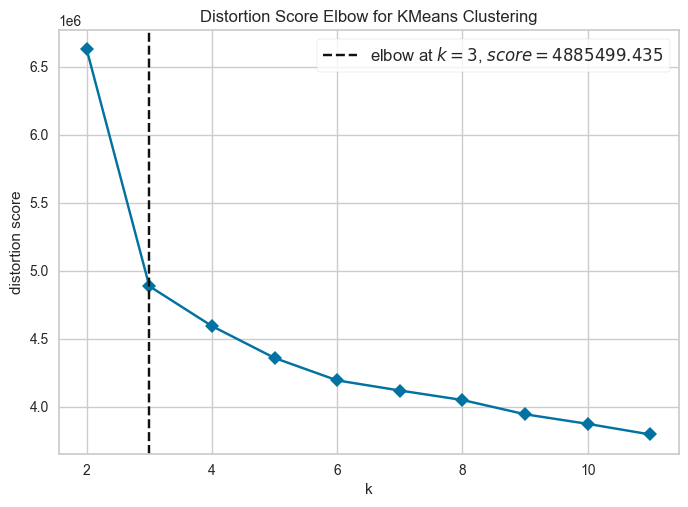

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Initialize KClusterer
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)
# Use KElbowVisualizer to find optimal number of clusters
visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,12),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False # Plot the timings to train?
                             )

visualizer.fit(sampled_df)       # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<p>We can see the optimal number of clusters is 5, since the elbow is at 5.</p>

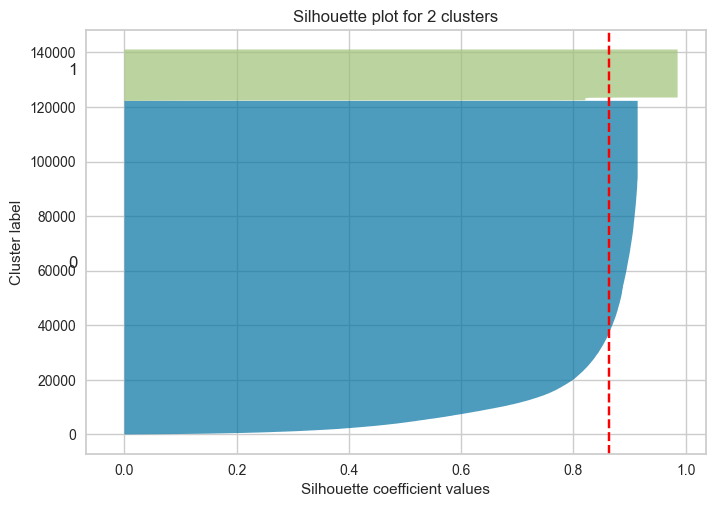

In [22]:
# Silhouette Analysis
def plot_silhouette(data, n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=2025)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          alpha=0.7)
        plt.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f"Silhouette plot for {n_clusters} clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# Run silhouette analysis with optimal clusters
plot_silhouette(sampled_df, 2)

<p>The elbow method gives us n=5 clusters.</p> 
<p>Now, let's use the silhouette method to identify the optimal number of clusters.</p>

<h2>Dimensionality Reduction</h2>

<h3>Apply PCA</h3>

In [23]:
# Redefine k-clusterer with optimal number of clusters
KClusterer = KMeans(n_clusters=2,
                    verbose=0,
                    random_state=2025)

# Fit the model
cluster_labels = KClusterer.fit_predict(sampled_df)

# Apply PCA to scaled data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(sampled_df)

# Wrap into DataFrame for visualization/analysis
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["Cluster"] = cluster_labels

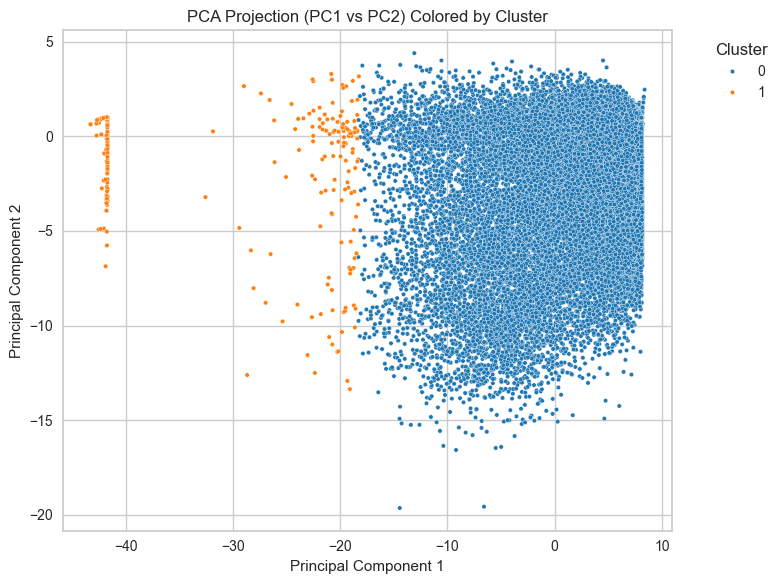

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=10)
plt.title("PCA Projection (PC1 vs PC2) Colored by Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [25]:
# Top contributing features for each component
components = pd.DataFrame(
    pca.components_, 
    columns=scaled_df.columns, 
    index=["PC1", "PC2", "PC3"]
)

for pc in components.index:
    print(f"\n{pc} top features:")
    print(components.loc[pc].abs().sort_values(ascending=False).head(5))

# Average PCA component values by cluster
avg_components_by_cluster = pca_df.groupby("Cluster")[["PC1", "PC2", "PC3"]].mean().reset_index()
print("\nAverage component values by cluster:")
print(avg_components_by_cluster)


PC1 top features:
HSFD003     0.057787
HSFD001S    0.057773
HSHO001     0.057772
HSHO001S    0.057772
HSTC001     0.057743
Name: PC1, dtype: float64

PC2 top features:
ECYHTAMED    0.418297
ECYPTAMED    0.417252
ECYHMAMED    0.346874
ECYPMAMED    0.346693
ECYMTNMED    0.309311
Name: PC2, dtype: float64

PC3 top features:
ECYMTNMED    0.191366
HSCC013      0.175420
HSCC002      0.159140
HSCC001      0.148358
HSCC003      0.148013
Name: PC3, dtype: float64

Average component values by cluster:
   Cluster        PC1       PC2       PC3
0        0   6.624128 -0.096759  0.049398
1        1 -43.022698  0.628435 -0.320829


<h3>UMAP</h3>
<p>Now we will apply UMAP to reduce the dimensionality of the data.</p>

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


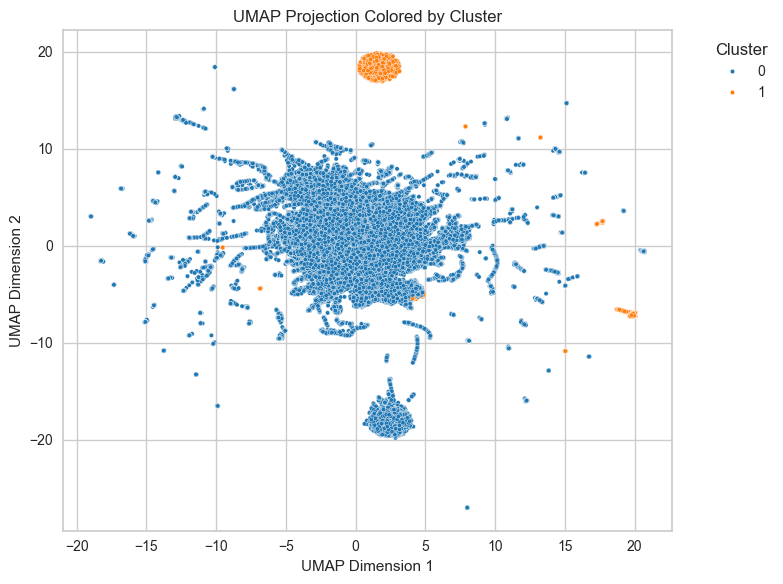

In [27]:
# UMAP with commonly good starting values
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.3)
umap_2d = umap_model.fit_transform(sampled_df)

# Create DataFrame
umap_df = pd.DataFrame(umap_2d, columns=["UMAP1", "UMAP2"])
umap_df["Cluster"] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=10)
plt.title("UMAP Projection Colored by Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p>UMAP appears to perform worse than PCA.</p>

<h1>Part 2: Regression</h1>

Now we will create models for a household’s proportion of income spent
on total personal insurance premiums and retirement/pension contributions.

Train a regularized elastic net linear regression from your data.

1. Create your target variable from the variables in the dataset. Do not use
those components on the training database.
2. Apply any data transformation / variable creation you deem necessary to
obtain a good result.
3. Discuss the grid that you chose to search for the parameters and the output
that you obtained.
4. For your test set, create a scatterplot of the original response and the
predicted response. Report the MSE and R2 on the test set and calculate a
bootstrapped confidence interval of the output.
5. Interpret the coefficients of the top five most important variables in the
regression